In [1]:
import pandas as pd 
import numpy as np
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv("C:/Users/hanna/Scape-Save-DAEN690/Datasets/indeed_cleaned.csv.gz") 
cos_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets/careeronestop_data.xlsx")
usa_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets/USAJobs_data.xlsx") 

### Data Cleaning

In [3]:
#Remove duplicate postings if the job title, description and location are the same 
df.drop_duplicates(subset=['job_title', 'description_text', 'location'], inplace=True)
cos_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)
usa_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)

In [4]:
def clean(text):
    #remove url
    output = re.sub(r'https://\S*','', text)

    #remove numerical values 
    output = ''.join(filter(lambda x: not x.isdigit(), output))

    #convert to lowercase 
    output = output.lower()

    #remove \r, \n
    rep = r'|'.join((r'\r',r'\n'))
    output = re.sub(rep,'',output)

    #remove duplicated punctuation
    output = re.sub(r'([!()\-{};:,<>./?@#$%\^&*_~]){2,}', lambda x: x.group()[0], output)
    
    #remove extra space
    output = re.sub(r'\s+', ' ', output).strip()
    
    #remove string if string only contains punctuation
    if sum([i.isalpha() for i in output])== 0:
        output = ''
        
    return output
    
df['description_text'] = df['description_text'].apply(clean)
#convert to unicode
cos_df['description'] = (cos_df['description'].values.astype("U"))
cos_df['description']= cos_df['description'].apply(clean)
usa_df['description'] = usa_df['description'].apply(clean)

In [5]:
#Set to lowercase so capitalized titles don't get counted separately
def lowercase(out): 
    out = out.lower()
    
    return out 

df['job_title'] = df['job_title'].apply(lowercase)
#convert to unicode 
cos_df['job_title'] = (cos_df['job_title'].values.astype("U"))
cos_df['job_title'] = cos_df['job_title'].apply(lowercase)
usa_df['job_title'] = usa_df['job_title'].apply(lowercase)

In [6]:
#Create function to categorize role types 

def role_type(x):
    if 'lead' in x:
        return 'senior'
    elif 'senior' in x:
        return 'senior'
    elif 'sr' in x:
        return 'senior'
    elif 'chief' in x:
        return 'upper mgmt'
    elif 'manager' in x:
        return 'upper mgmt'
    elif 'principal' in x:
        return 'upper mgmt'
    elif 'junior' in x:
        return 'entry-level'
    elif 'jr' in x:
        return 'entry-level'
    elif 'entry-level' in x:
        return 'entry-level'
    elif 'entry level' in x:
        return 'entry-level'
    elif 'professor' in x: 
        return 'academia'
    else:
        return 'other'
    
df['role_type'] = df['job_title'].apply(role_type)
cos_df['role_type'] = cos_df['job_title'].apply(role_type)
usa_df['role_type'] = usa_df['job_title'].apply(role_type)

#Can be used for visualizations 
df_in = df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_cos = cos_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_usa = usa_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]

### BERTopic Model

In [7]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
# ngram_range set to 2 so the topics extracted can also be 'two-words' instead of one 
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Fine-tune topic representations with 
# reduces redundacy and improve diversity of keywords using MMR 
representation_model = MaximalMarginalRelevance(0.4)

#CareerOneStop model 
topic_model = BERTopic(
  embedding_model=embedding_model, # Step 1: Embedding        
  umap_model=umap_model, # Step 2: Dimensionality reduction                   
  hdbscan_model=hdbscan_model, # Step 3: Clustering              
  vectorizer_model=vectorizer_model, # Step 4: Tokenizer         
  ctfidf_model=ctfidf_model, # Step 5: Weighting scheme                
  representation_model=representation_model, nr_topics=20) # Step 6: Fine-tune topic representation 

#Indeed model 
topic_model_in = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=20) 

#USAjobs model 
topic_model_usa = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=20)

In [8]:
#Indeed model
topic_in, prob_in = topic_model_in.fit_transform(df['description_text'].values.astype('U'))

In [9]:
#CareerOneStop model
topic, prob = topic_model.fit_transform(cos_df['description'].values.astype('U'))

In [10]:
#USAjobs model 
topic_usa, prob_usa = topic_model_usa.fit_transform(usa_df['description'].values.astype('U'))

In [11]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1745,-1_experience_systems_cybersecurity_management
1,0,5738,0_experience_management_technical_cybersecurity
2,1,291,1_experience_information security_applicants_w...
3,2,286,2_rubrik_minimum maximum_salaries role_employment
4,3,167,3_relativity_discovery_litigation_experience
5,4,113,4_guidehouse_navair_adfs_resumes
6,5,82,5_td bank_information security_technology cont...
7,6,73,6_icf com_pay_working icf_icfcareercenter icf
8,7,67,7_cybersecurity_automotive_development_experience
9,8,65,8_testing_penetration testing_eurofins_experience


In [12]:
topic_model_usa.get_topic_info()

,Topic,Count,Name
0,-1,35,-1_systems_technical_position_information
1,0,60,0_fema_dhs_emergency management_federal
2,1,17,1_construction_staff_projects_committee
3,2,33,2_va_safety_including limited_biomedical
4,3,12,3_specialists_vacancies_opm_management analysts
5,4,12,4_telework_applications_career transition_job
6,5,22,5_dental_information_applicants_employment
7,6,40,6_certification_reemployed annuitant_employmen...
8,7,74,7_service_federal_position_physical
9,8,20,8_ic_intelligence products_cyberspace_squadron


In [13]:
topic_model_in.get_topic_info()

,Topic,Count,Name
0,-1,3595,-1_experience_cybersecurity_requirements_skills
1,0,5277,0_experience_cybersecurity_technical_risk
2,1,319,1_faculty_students_teaching_umgc
3,2,241,2_experience_network security_cisco_infrastruc...
4,3,182,3_testing_penetration testing_vulnerabilities_...
5,4,158,4_experience_requires_engineering_cybersecurity
6,5,154,5_security_northrop grumman_employees_experience
7,6,87,6_usa remote_kimberly clark_kimberly_clark
8,7,83,7_years_internship_degree_cybersecurity
9,8,48,8_security_nrel_technical_systems


In [14]:
freq = topic_model.get_topic_info()

In [15]:
topic_model_in.visualize_barchart()

In [16]:
topic_model.visualize_barchart()

In [17]:
topic_model_usa.visualize_barchart()

In [18]:
topic_model.get_topic(freq.iloc[4]["Topic"])

[('relativity', 0.026057008552983155),
 ('discovery', 0.023652656741128746),
 ('litigation', 0.021298630922206796),
 ('experience', 0.01833639927999643),
 ('forensic', 0.017574625583425794),
 ('foia', 0.015208382402487406),
 ('analytics', 0.01210570810779153),
 ('help clients', 0.011346005071463331),
 ('requests', 0.010964081537651861),
 ('ediscovery', 0.00904115894620886)]

In [19]:
topic_model.visualize_heatmap()

In [20]:
topic_model_in.visualize_heatmap()

In [21]:
topic_model_usa.visualize_heatmap()

In [22]:
#merge topics with similarities > 0.85 
#topics_to_merge = [0,14]
#topic_model_in.merge_topics(df['description_text'], topics_to_merge)

### Topic Mapping 

In [23]:
#Add the topic for each record in the dataframe - CareerOneStop & Indeed Data
cos_df['topic'] = topic
df['topic_in'] = topic_in

In [24]:
#Group all keywords with a certain topic
topic_0 = cos_df[cos_df['topic'] == 0].groupby('keyword')['keyword'].count()
topic_1 = cos_df[cos_df['topic'] == 1].groupby('keyword')['keyword'].count()
topic_2 = cos_df[cos_df['topic'] == 2].groupby('keyword')['keyword'].count()
topic_3 = cos_df[cos_df['topic'] == 3].groupby('keyword')['keyword'].count()
topic_4 = cos_df[cos_df['topic'] == 4].groupby('keyword')['keyword'].count()

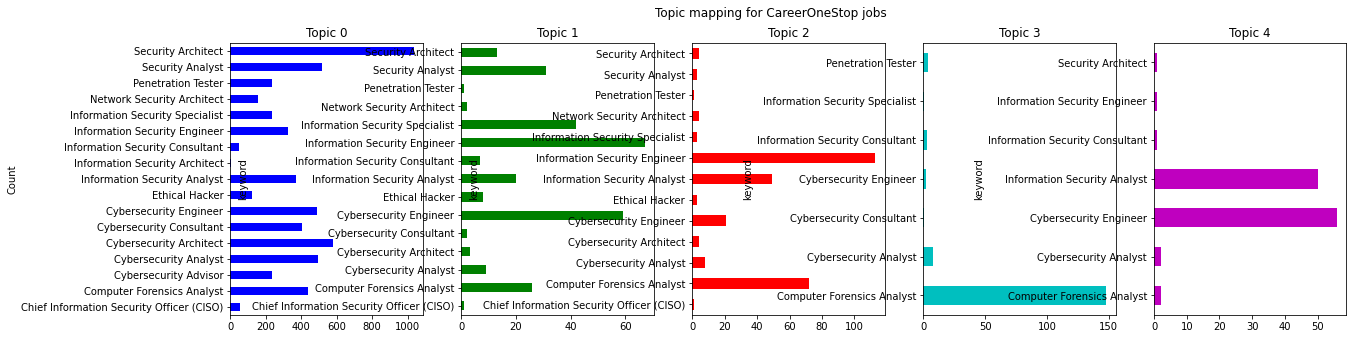

In [25]:
#Barplots showing the job families for each topic
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# plot each series on a different subplot
topic_0.plot.barh(ax=axs[0], color='b')
topic_1.plot.barh(ax=axs[1], color='g')
topic_2.plot.barh(ax=axs[2], color='r')
topic_3.plot.barh(ax=axs[3], color='c')
topic_4.plot.barh(ax=axs[4], color='m')

# set titles and labels for each subplot
axs[0].set_title('Topic 0')
axs[1].set_title('Topic 1')
axs[2].set_title('Topic 2')
axs[3].set_title('Topic 3')
axs[4].set_title('Topic 4')
axs[0].set_ylabel('Count')


# set a title for the figure
fig.suptitle('Topic mapping for CareerOneStop jobs')

# display the plot
plt.show()